## <font color=orange>Timeline Notes:</font>

1. March 09 First infected within US
1. March 12 Evers declares disease public health emergency
1. March 13 Evers closes schools and Trump announces COVID-19 a global pandemic
1. March 16 Dane Country declared state of emergency and community spread identified
1. March 17 Evers closes bars and restaurants and bans gatherings of 10+
1. March 23 'Safer at Home' iniative put in place
1. April 07 Primary election takes place after Evers's decison to postpone is overruled

[Souce](https://wkow.com/2020/03/23/how-did-we-get-here-a-wisconsin-coronavirus-timeline/)

In [1]:
import requests, io
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.animation as animation
from IPython.core.display import HTML
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression

class CovidData:
    def __init__(self, name=str, state=None, county=False, pop=False, start_date=datetime(2020,3,1), end_date=None, num_day=4, style='seaborn-whitegrid'):
        self.name = name
        #US COVID-19 data by John's Hopkins from GitHub
        self.urls = {'Cases': 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
                     'Deaths': 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'}
        self.regions = {'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Maryland', 'Delaware'],
           'South': ['West Virginia', 'Virginia', 'Kentucky', 'Tennessee', 'North Carolina', 'South Carolina', 'Arkansas', 'Louisiana', 'Mississippi', 'Alabama', 'Georgia', 'Florida'],
           'Midwest': ['North Dakota', 'Minnesota', 'Wisconsin', 'Michigan', 'South Dakota', 'Iowa', 'Nebraska', 'Kansas', 'Missouri', 'Illinois', 'Indiana', 'Ohio'],
           'West': ['Arizona', 'New Mexico', 'Texas', 'Oklahoma', 'Alaska', 'Washington', 'Oregon', 'Idaho', 'Montana', 'Wyoming', 'California', 'Nevada', 'Utah', 'Colorado', 'Hawaii']}
        self.num2str = ['ones', 'tens', 'hundreds', 'thousands', 'ten-thousands', 'hundred-thousands', 'millions']
        self.state = state
        self.county = county
        self.pop = pop
        self.start_date = start_date
        self.end_date = end_date
        self.num_day = num_day
        self.style = style
        self.us_map = gpd.read_file('zip://state_shape.zip')
        self.county_map = gpd.read_file('zip://county_shape.zip')
        self.state_codes = {}
        for row in self.us_map.itertuples():
            self.state_codes[row.STATEFP] = row.NAME
        self.county_map['STATEFP'] = self.county_map.apply(lambda row: self.state_codes[row.STATEFP], axis=1)
    
    def get_data(self):
    #Pull data and read into a aataframe...data is CSV file of cases by location (typically a city) since Jan 22nd
        r = requests.get(self.urls[self.name]).content
        df = pd.read_csv(io.StringIO(r.decode('utf-8'))).dropna()
        if self.county:
            if isinstance(self.state, list):
                df = df.set_index('Province_State').loc[self.state]
                self.county_map = self.county_map.set_index('STATEFP').loc[self.state]
            elif self.state in self.regions:
                region = self.regions[self.state]
                df = df.set_index('Province_State').loc[region]
                self.county_map = self.county_map.set_index('STATEFP').loc[region]
            elif self.state == None:
                self.county_map = self.county_map.set_index('STATEFP')
                df['Combined_Key'] = df.apply(lambda row: ', '.join(row.Combined_Key.split(', ')[:2]), axis=1)
                df = pd.read_csv('CountyPopEst.csv', index_col=0).join(df.set_index('Combined_Key')).dropna()
                return df
            else:
                df = df[df['Province_State']==self.state]
                self.county_map = self.county_map[self.county_map['STATEFP'] == self.state]
            self.base_df = df.set_index('Admin2')
            return self.base_df
        else:
            df = df.groupby('Province_State').sum().append(pd.Series(df.sum(numeric_only=True), name='United States'))
            for region in self.regions:
                df = df.append(pd.Series(df.loc[self.regions[region]].sum(numeric_only=True), name=region))
        #Select only data from selected state
        if self.state == 'all':
            self.base_df = df
            return df
        elif self.state != None:
            if isinstance(self.state, str):
                self.state = [self.state]
            for state in self.state:
                if state not in df.index:
                    print(state)
                    raise ValueError('Invalid state input...is everything spelt correctly?')
            df = df.loc[self.state]
        else:
            df = df.loc[['United States']]
        self.base_df = df
        return self.base_df
    
    def slice_data(self):
    #Slice so only rows of dates are present and then compute the cases from each day instead of cumalative totals
        self.get_data()
        start = self.start_date.strftime('%-m/%-d/%y')
        if self.end_date == None:
            totals = self.base_df.loc[:, start:]
        else:
            end = self.end_date.strftime('%-m/%-d/%y')
            totals = self.base_df.loc[:, start:end]
        self.totals = totals
        if self.pop:
            if isinstance(self.state, str):
                self.state = [self.state]
            with open('StatePop.csv') as f:
                pop = pd.read_csv(f)
            pop = pop[['Geographic Area','2019']].set_index('Geographic Area').loc[self.state]
            totals = totals.loc[self.state]
            self.totals = totals.div(pop.values)*100000
        return self.totals
    
    def get_daily(self):
    #Create a new dataframe to have daily cases rather than cumaltive sum
        self.slice_data()
        prev = (self.start_date - timedelta(days=1)).strftime('%-m/%-d/%y')
        if self.end_date == None:
            end = self.base_df.columns[-2]
        else:
            end = (self.end_date - timedelta(days=1)).strftime('%-m/%-d/%y')
        tmp = self.base_df.loc[:, prev:end]
        col_names = {temp:tot for tot, temp in zip(self.totals.columns, tmp.columns)}
        tmp = tmp.rename(columns=col_names)
        daily = (self.totals - tmp).T.reset_index().rename(columns={'index':'date'})
        daily['date'] = pd.to_datetime(daily['date'])
        self.daily_df = daily.set_index('date')
        return self.daily_df
    
    def group_days(self):
    #Group data by a specified amount of days (or weekly if desired) add extra blank row for graphing
        self.get_daily()
        time_range = timedelta(days=self.num_day)
        df = self.daily_df.resample(time_range, label='left').mean().reset_index()
        self.grouped = df.append(pd.Series({'date':df.iloc[-1, 0] + timedelta(self.num_day)}), ignore_index=True)
        return self.grouped
    
    def rescale(self, df):
    #Get scaling factor for graphs so axes are more readable
        avg = df.mean()
        log = np.log10(avg)//1
        exp = log.astype(int).max()
        return (10**exp, exp)

    def bar(self, rows, cols, idx):
    #Create bar plot of total cases
        ax = plt.subplot(rows, cols, idx)
        df = self.grouped.set_index('date')
        if not self.pop:
            scalar, exp = self.rescale(df)
            df /= scalar
        df.reset_index().plot.bar('date', width=.9, edgecolor='white', ax=ax)
        labels = self.grouped['date'].dt.strftime('%b %d')
        if self.pop:
            if len(self.state) == 1:
                ax.legend([f'Average Daily {self.name})'], fontsize='large', loc=2)
            else:
                ax.legend(title=f'Average Daily {self.name})', fontsize='large', loc=2)
        else:
            if len(self.state) == 1:
                ax.legend([f'Average Daily {self.name}\n({self.num2str[exp]})'], fontsize='large', loc=2)
            else:
                ax.legend(title=f'Average Daily {self.name}\n({self.num2str[exp]})', fontsize='large', loc=2)
        ax.set_xticklabels(labels, rotation=-45)
        ax.set_xlabel(None)
        ax.set_xlim(-.25, ax.get_xticks()[-1]+.25)
    
    def line(self, rows, cols, idx):
    #Create line plot of total cases
        ax = plt.subplot(rows, cols, idx)
        low, high, step = (0, len(self.totals.T), self.num_day)
        df = self.totals.T
        if not self.pop:
            scalar, exp = self.rescale(df)
            df /= scalar
        df.reset_index().plot(ax=ax, marker='o', markevery=slice(low, high, step))
        ax.yaxis.tick_right()
        if not self.pop:
            if len(self.state) == 1:
                ax.legend([f'Total {self.name}\n({self.num2str[exp]})'], fontsize='large', loc=2)
            else:
                ax.legend(title=f'Total {self.name}\n({self.num2str[exp]})', fontsize='large', loc=2)
        else:
            if len(self.state) == 1:
                ax.legend([f'Total {self.name}'], fontsize='large', loc=2)
            else:
                ax.legend(title=f'Total {self.name})', fontsize='large', loc=2)
        ax.set_xticks(range(low, high, step))
        labels = self.grouped['date'].dt.strftime('%b %d')
        ax.set_xticklabels(labels, rotation=-45)
        
    def cplot(self, plot, descrp=None):
        self.group_days()
        plt.style.use(self.style)
        if self.state==None:
            self.state = ['United States']
    #Set up subplots
        if callable(plot):
            plot = [plot]
        num = len(plot)
        if num == 1 or isinstance(plot, str):
            rows = cols = 1
        elif num == 2:
            rows, cols = 1, 2
        elif num == 3:
            rows, cols = 1, 3
        elif num == 4:
            rows = cols = 2
        else:
            raise ValueError('Number of plots input is too high to be displayed well')
        
        fig, ax = plt.subplots(rows, cols, figsize=(12/rows, 12/cols))
        if isinstance(plot, str):
            getattr(self, plot)(rows, cols, 1)
        else:
            for idx, plot in enumerate(plot):
                idx += 1
                getattr(self, plot)(rows, cols, idx)
            
    #Add a subplot on top of others to havea common title
        fig.add_subplot(111, frame_on=False)
        plt.grid(False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        
        if len(self.state) == 1:
            text = self.state[0]
        else:
            text = '/'.join(self.state) 
        pop_text = ''
        if self.pop:
            pop_text = ' per 100,000'
        plt.title(f'Number of Confirmed COVID-19 {self.name}{pop_text} in {text}', fontsize=18)

    #Remove excess white space, save, and display plots
        if descrp != None:
            plt.figtext(0.5, 0.01, descrp, wrap=True, ha='center', fontsize=14)
            
        if len(self.state) == 1:
            text = self.state[0].replace(' ', '')
        else:
            states = self.state
            for idx, state in enumerate(states):
                self.state[idx] = state.replace(' ', '')
            text = '+'.join(states)
        fig.tight_layout()
        plt.savefig(f'pages/covid{text}{self.name}.png')
        plt.close()
        return fig 
    
    def animate(self):
        df = self.slice_data()
        dates = df.columns
        merged = self.us_map.set_index('NAME').join(df)
        fig, ax = plt.subplots(figsize=(15,7))
        def draw_frame(frame_num, dates=dates, fig=fig, ax=ax):
            ax.clear()
            if len(fig.axes) > 1:
                fig.delaxes(fig.axes[1])
            date = dates[frame_num]
            bins = merged[date].quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])
            vmin, vmax = merged[date].min(), merged[date].max()
            med = merged[date].median()
            merged.plot(column=date, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', classification_kwds={'bins':bins})
            ax.set_xlim([-125, -65])
            ax.set_ylim([25, 50])
            ax.axis('off')
            ax.set_title('# of Confirmed Cases of Covid-19', fontdict={'fontsize': '18', 'fontweight' : '3'})
            ax.annotate(date,xy=(0.1, .225), xycoords='figure fraction', ha='left', va='top', fontsize=16)
            ax.annotate(f'Median: {med}',xy=(0.1, .175), xycoords='figure fraction', ha='left', va='top', fontsize=16)
            ax.annotate(f'Max: {vmax}',xy=(0.1, .125), xycoords='figure fraction', ha='left', va='top', fontsize=16)
            sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = fig.colorbar(sm, cax=cax)
            fig.tight_layout()

        writervideo = animation.FFMpegWriter(fps=60) 
        anim = FuncAnimation(fig, draw_frame, frames=len(dates), interval=400, repeat=False)
        anim.save('pages/animation.mp4', writer=writervideo)
        html = anim.to_html5_video()
        plt.close(fig)
        return HTML(html)
        
    def counties(self):
    #Plot cases by county   
        df = self.slice_data()#.set_index('Admin2')
        fig, ax = plt.subplots(figsize=(10,10))
        merged = self.county_map.set_index('NAME').join(df)
        date = df.columns[-1]
        vmin, vmax = merged[date].min(), merged[date].max()
        merged.plot(column=date, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
        ax.axis('off')
        ax.set_title('# of Confirmed Cases of Covid-19', fontdict={'fontsize': '18', 'fontweight' : '3'})
        sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size="5%", pad=0.05)
        cbar = fig.colorbar(sm, cax=cax)
        fig.tight_layout()
        plt.savefig(f'pages/county{self.state}.png')
        
    def pop_dens(self):
        df = self.slice_data()
        with open('StatePop.csv') as f:
            pop = pd.read_csv(f)
        pop = pop[['Geographic Area','2019']].set_index('Geographic Area')
        us_map = self.us_map.set_index('NAME')
        us_map['ALAND'] = us_map['ALAND']/1e6
        dens = us_map.join(pop).rename(columns={'2019':'population'})
        dens['pop_dens'] = dens.apply(lambda row: row.population/row.ALAND, axis=1)
        dens['cases'] = df[df.columns[-1]]
        dens['per_100k'] = dens.apply(lambda row: row.cases/row.population * 100000, axis=1)
        dens = dens.sort_values('per_100k').dropna().drop('District of Columbia')
        
        fig, ax = plt.subplots(figsize=(8,8))
        x = dens['pop_dens'].to_numpy().reshape(-1,1)
        y = dens['per_100k'].to_numpy().reshape(-1,1)
        sns.scatterplot('pop_dens', 'per_100k', data=dens)
        ax.set_title(f'Correlation of State Population Density and Number of {self.name}', fontsize=16)
        ax.set_xlabel('Population Density (per Km^2)', fontsize=14)
        ax.set_ylabel(f'{self.name} per 100,000', fontsize=14)
        
        r = LinearRegression()
        r.fit(x, y)
        r2 = r.score(x,y)
        m = r.coef_
        b = r.intercept_[0]
        y = m*x + b
        ax.text(0.1, .9, f'y = {round(m[0][0], 2)}x +{round(b, 2)}', fontsize=12, transform=ax.transAxes)
        ax.text(0.1, .85, f'R^2 = {round(r2, 4)}', fontsize=12, transform=ax.transAxes)
        plt.plot(x,y,'r')
        fig.tight_layout()
        plt.savefig(f'pages/{self.name}correlation.png')
        plt.close()
        return fig

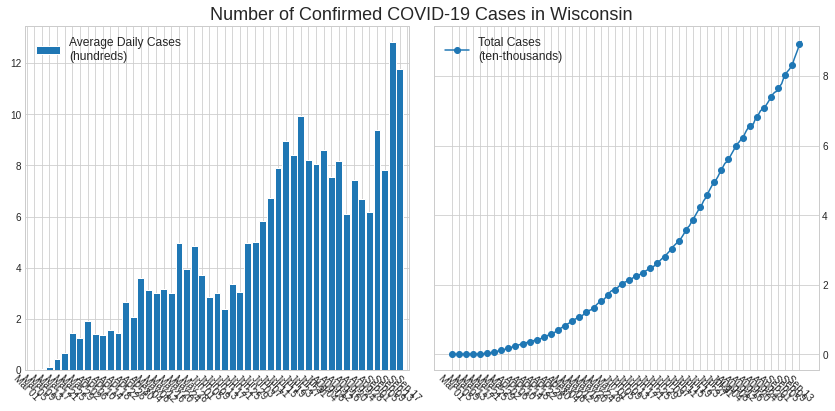

In [2]:
casesUS = CovidData('Cases', 'Wisconsin')
#text = 'Figure 1: Number of confirmed daily cases averaged over 4 days (left) and total number of confirmed cases in the United States (right)'
casesUS.cplot(['bar', 'line'])

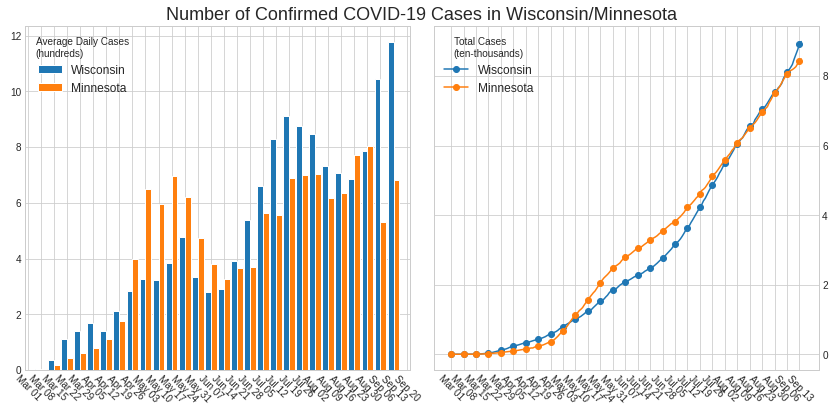

In [3]:
casesWI_MN = CovidData('Cases', ['Wisconsin', 'Minnesota'], num_day=7)
casesWI_MN.cplot(['bar', 'line'])

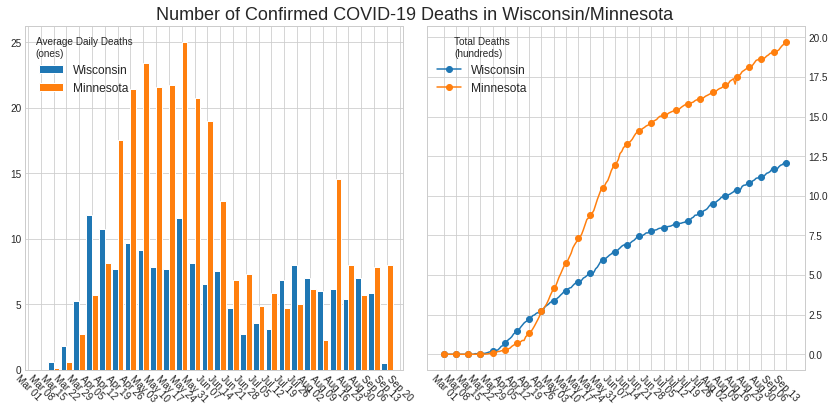

In [4]:
deathsWI_MN = CovidData('Deaths', ['Wisconsin', 'Minnesota'], num_day=7)
text = 'Figure 1: Number of deaths averaged over 4 days (left) and total number of deaths(right) in Wisconsin vs Minnesota'
deathsWI_MN.cplot(['bar', 'line'])

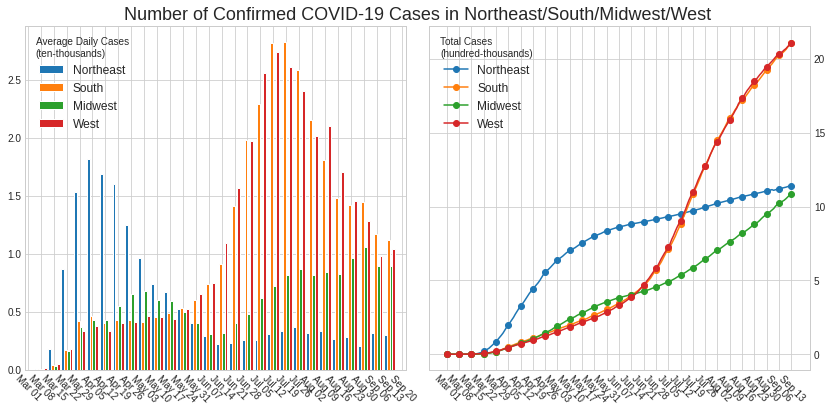

In [5]:
casesRegion = CovidData('Cases', ['Northeast', 'South', 'Midwest','West'], num_day=7)
casesRegion.cplot(['bar','line'])

KeyboardInterrupt: 

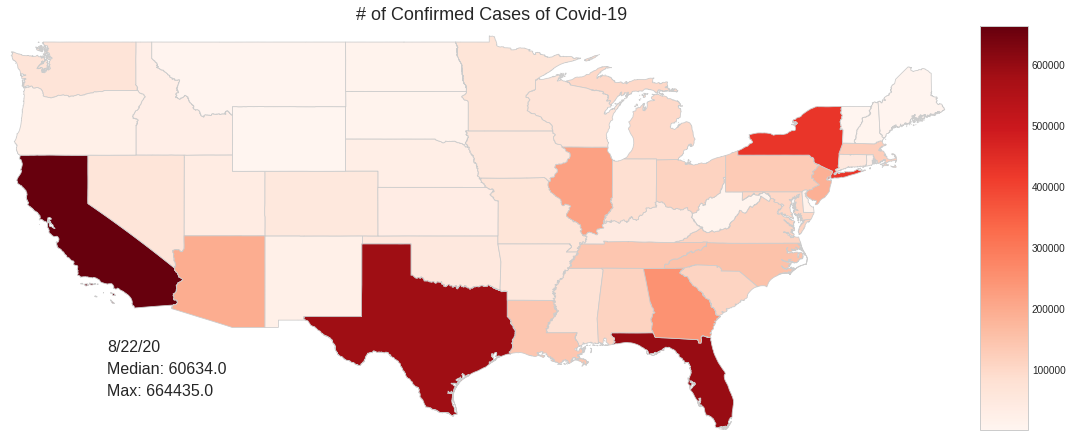

In [13]:
casesAnim = CovidData('Cases', 'all')
casesAnim.animate()

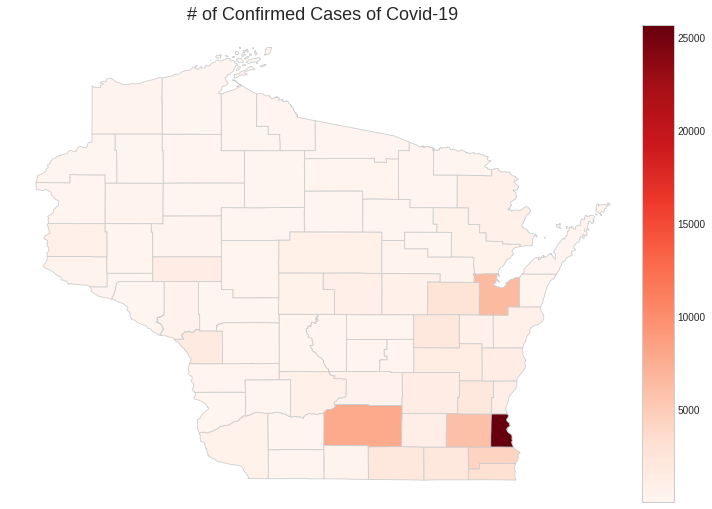

In [14]:
countyWI = CovidData('Cases', 'Wisconsin', True)
countyWI.counties()

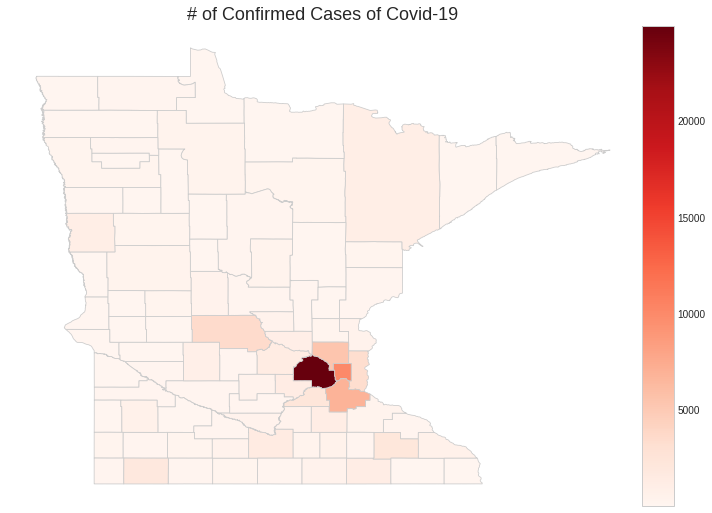

In [15]:
countyMN = CovidData('Cases', 'Minnesota', True)
countyMN.counties()

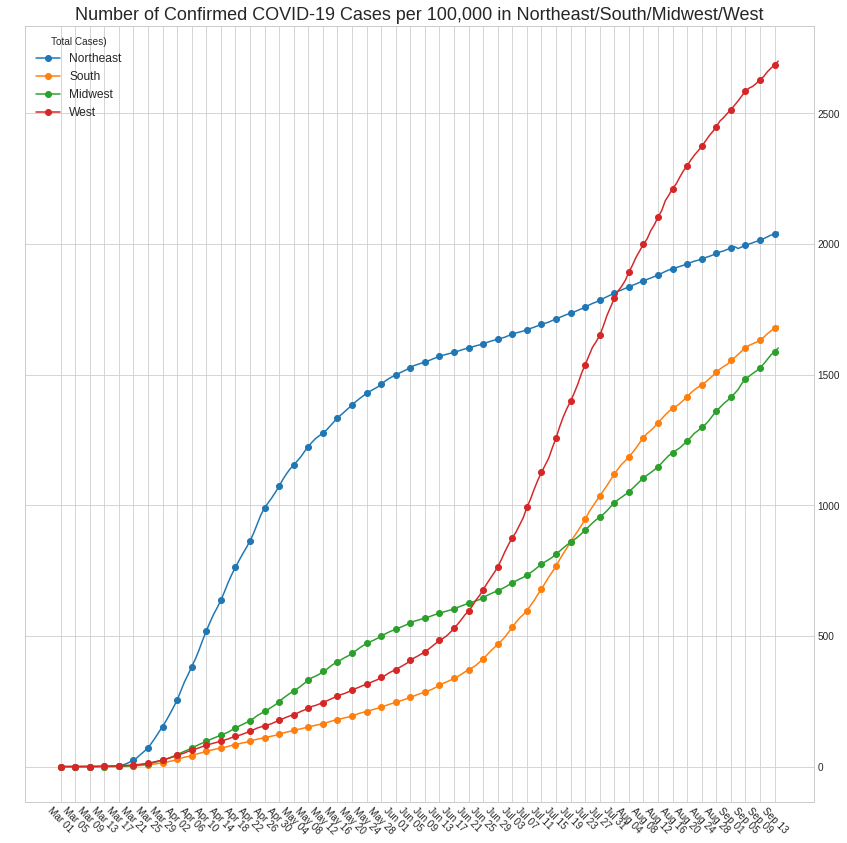

In [16]:
popRegion = CovidData('Cases', ['Northeast', 'South', 'Midwest','West'], pop=True)
popRegion.cplot('line')

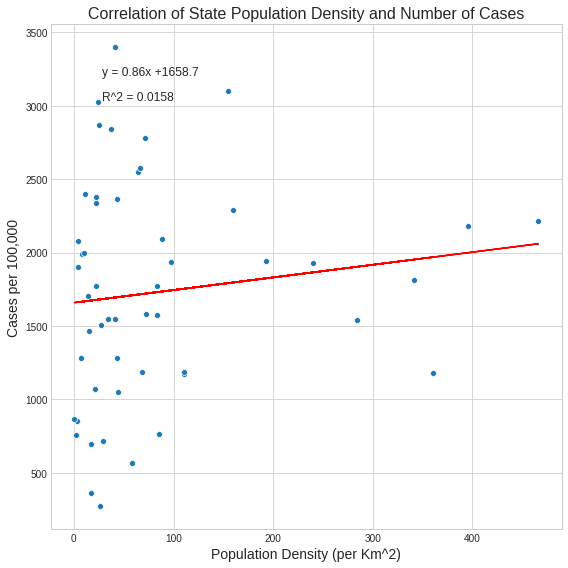

In [17]:
popWI = CovidData('Cases', 'all')
popWI.pop_dens()

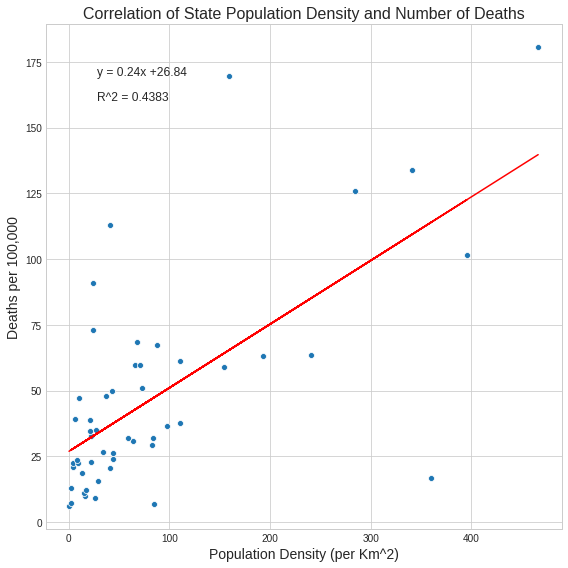

In [18]:
popdWI = CovidData('Deaths', 'all')
popdWI.pop_dens()

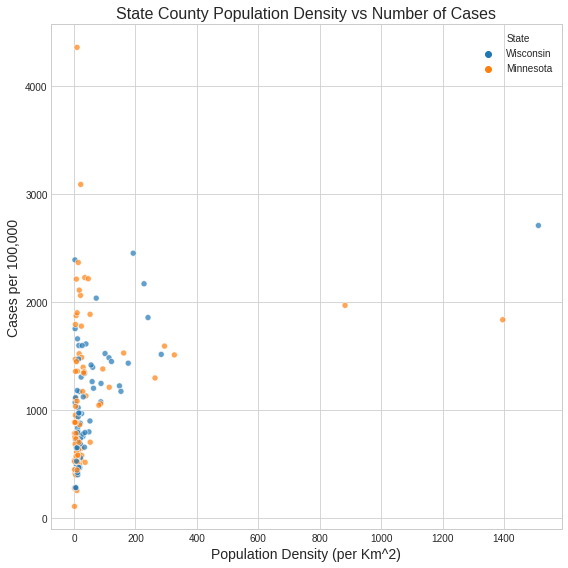

In [12]:
scatCounty = CovidData('Cases', county=True)
df = scatCounty.get_data()
us_map = gpd.read_file('zip://state_shape.zip')
state_codes = {}
for row in us_map.itertuples():
    state_codes[row.STATEFP] = row.NAME
county_map = gpd.read_file('zip://county_shape.zip')
county_map['ALAND'] = county_map['ALAND']/1e6
county_map['index'] = county_map.apply(lambda row: f'{row.NAME}, {state_codes[row.STATEFP]}', axis=1)
county_map['STATEFP'] = county_map.apply(lambda row: state_codes[row.STATEFP], axis=1)
county = county_map.set_index('index').join(df).dropna()
county

county['pop_dens'] = county.apply(lambda row: row.Population/row.ALAND, axis=1)
county['cases'] = df[df.columns[-1]]
county['per_100k'] = county.apply(lambda row: row.cases/row.Population * 100000, axis=1)
county = county[county.STATEFP.isin(['Minnesota', 'Wisconsin'])].drop('Nobles, Minnesota').rename(columns={'STATEFP': 'State'})
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot('pop_dens', 'per_100k', hue='State', data=county, alpha=0.7)
plt.style.use('seaborn-whitegrid')
ax.set_title('State County Population Density vs Number of Cases', fontsize=16)
ax.set_xlabel('Population Density (per Km^2)', fontsize=14)
ax.set_ylabel('Cases per 100,000', fontsize=14)
fig.tight_layout()
plt.savefig('pages/scatter.png')
plt.show()